# Data Preparation

This notebook applies the data cleaning and preparation decisions
defined in the data audit step.

**Objectives:**
- Apply data type corrections identified in the audit
- Handle missing values with business-justified decisions
- Validate data integrity and consistency
- Produce a clean dataset ready for EDA and modeling

## 1. Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. TotalCharges Conversion

As identified in the data audit, `TotalCharges` is stored as an object type
due to empty strings representing missing values.

In [3]:
# Check current state
print(f"TotalCharges dtype before: {df['TotalCharges'].dtype}")
print(f"Empty strings count: {(df['TotalCharges'].astype(str).str.strip() == '').sum()}")

TotalCharges dtype before: object
Empty strings count: 11


In [4]:
# Convert TotalCharges to numeric (empty strings become NaN)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [5]:
# Validate the conversion
print("=== Conversion Validation ===")
print(f"TotalCharges dtype after: {df['TotalCharges'].dtype}")
print(f"TotalCharges range: {df['TotalCharges'].min():.2f} - {df['TotalCharges'].max():.2f}")
print(f"Missing values after conversion: {df['TotalCharges'].isna().sum()}")

=== Conversion Validation ===
TotalCharges dtype after: float64
TotalCharges range: 18.80 - 8684.80
Missing values after conversion: 11


## 3. Missing Values Analysis

The 11 missing values in `TotalCharges` need to be understood
before deciding how to handle them.

In [16]:
# Examine rows with missing TotalCharges
missing_total = df[df["TotalCharges"].isna()]

print(f"Rows with missing TotalCharges: {len(missing_total)}")
missing_total[["customerID", "tenure", "MonthlyCharges", "TotalCharges", "Churn"]]

Rows with missing TotalCharges: 11


,customerID,tenure,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,0,52.55,NaN,No
753,3115-CZMZD,0,20.25,NaN,No
936,5709-LVOEQ,0,80.85,NaN,No
1082,4367-NUYAO,0,25.75,NaN,No
1340,1371-DWPAZ,0,56.05,NaN,No
3331,7644-OMVMY,0,19.85,NaN,No
3826,3213-VVOLG,0,25.35,NaN,No
4380,2520-SGTTA,0,20.00,NaN,No
5218,2923-ARZLG,0,19.70,NaN,No
6670,4075-WKNIU,0,73.35,NaN,No


In [17]:
# Verify: Are all missing TotalCharges for tenure = 0?
print(f"Tenure values for missing TotalCharges: {missing_total['tenure'].unique()}")
print(f"All missing TotalCharges have tenure = 0: {(missing_total['tenure'] == 0).all()}")

Tenure values for missing TotalCharges: [0]
All missing TotalCharges have tenure = 0: True


### Missing Values — Business Decision

**Observation:**
- All 11 missing values in `TotalCharges` correspond to customers with `tenure = 0`
- These are new customers who have not yet been billed

**Decision:**
- **Keep NaN values** — do not impute with 0
- Rationale: `TotalCharges = 0` would imply "billed zero dollars", which is incorrect
- NaN correctly represents "not yet billed"
- The model will handle this via imputation with a missing indicator during preprocessing

This decision is driven by **business logic**, not technical convenience.

## 4. Data Consistency Check (Sanity Check)

Verify that `TotalCharges` is consistent with `tenure × MonthlyCharges`.

In [18]:
# Calculate expected total charges for customers with tenure > 0
df_check = df[df["tenure"] > 0].copy()
df_check["expected_total"] = df_check["tenure"] * df_check["MonthlyCharges"]
df_check["charge_ratio"] = df_check["TotalCharges"] / df_check["expected_total"]

print("Ratio of TotalCharges / (tenure × MonthlyCharges):")
print(df_check["charge_ratio"].describe())

Ratio of TotalCharges / (tenure × MonthlyCharges):
count    7032.000000
mean        1.000275
std         0.051159
min         0.689356
25%         0.979546
50%         1.000000
75%         1.019562
max         1.573454
Name: charge_ratio, dtype: float64


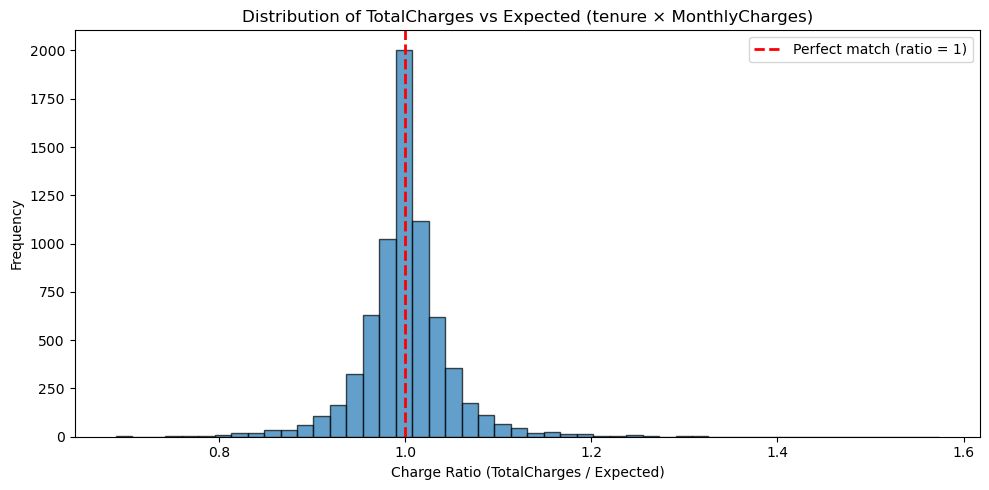

In [19]:
# Visualize the distribution of charge ratios
plt.figure(figsize=(10, 5))
plt.hist(df_check["charge_ratio"], bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Charge Ratio (TotalCharges / Expected)")
plt.ylabel("Frequency")
plt.title("Distribution of TotalCharges vs Expected (tenure × MonthlyCharges)")
plt.axvline(1.0, color="red", linestyle="--", linewidth=2, label="Perfect match (ratio = 1)")
plt.legend()
plt.tight_layout()
plt.show()

### Sanity Check — Interpretation

The charge ratio distribution shows that `TotalCharges` is generally consistent
with `tenure × MonthlyCharges`, but not exactly equal.

**Possible explanations for variance:**
- Price changes over the customer's lifetime
- Promotions or discounts applied
- Service upgrades or downgrades
- One-time fees or credits

**Conclusion:** The data is consistent and realistic. No anomalies detected.

## 5. Transformation Log

Documentation of all transformations applied in this notebook.

In [20]:
# Transformation log as a DataFrame
transformation_log = pd.DataFrame({
    "Column": ["TotalCharges"],
    "Original Type": ["object"],
    "New Type": ["float64"],
    "Action": ["Converted to numeric; empty strings → NaN"],
    "Rows Affected": [11],
    "Business Justification": ["NaN represents 'not yet billed' for new customers"]
})

transformation_log

,Column,Original Type,New Type,Action,Rows Affected,Business Justification
0,TotalCharges,object,float64,Converted to numeric; empty strings → NaN,11,NaN represents 'not yet billed' for new customers


## 6. Data Dictionary

Create a comprehensive data dictionary for documentation and future reference.

In [21]:
# Data dictionary
data_dictionary = {
    "customerID": "Unique customer identifier (not used in modeling)",
    "gender": "Customer gender (Male/Female)",
    "SeniorCitizen": "Whether customer is senior citizen (0=No, 1=Yes)",
    "Partner": "Whether customer has a partner (Yes/No)",
    "Dependents": "Whether customer has dependents (Yes/No)",
    "tenure": "Number of months with the company (0-72)",
    "PhoneService": "Whether customer has phone service (Yes/No)",
    "MultipleLines": "Whether customer has multiple lines (Yes/No/No phone service)",
    "InternetService": "Type of internet service (DSL/Fiber optic/No)",
    "OnlineSecurity": "Whether customer has online security add-on (Yes/No/No internet service)",
    "OnlineBackup": "Whether customer has online backup add-on (Yes/No/No internet service)",
    "DeviceProtection": "Whether customer has device protection add-on (Yes/No/No internet service)",
    "TechSupport": "Whether customer has tech support add-on (Yes/No/No internet service)",
    "StreamingTV": "Whether customer has streaming TV add-on (Yes/No/No internet service)",
    "StreamingMovies": "Whether customer has streaming movies add-on (Yes/No/No internet service)",
    "Contract": "Contract type (Month-to-month/One year/Two year)",
    "PaperlessBilling": "Whether customer uses paperless billing (Yes/No)",
    "PaymentMethod": "Payment method (Electronic check/Mailed check/Bank transfer (automatic)/Credit card (automatic))",
    "MonthlyCharges": "Current monthly charge amount in dollars",
    "TotalCharges": "Total charges to date in dollars (NaN for new customers with tenure=0)",
    "Churn": "Target variable — whether customer churned (Yes/No)"
}

# Convert to DataFrame
data_dict_df = pd.DataFrame(
    data_dictionary.items(),
    columns=["Column", "Description"]
)

data_dict_df

,Column,Description
0,customerID,Unique customer identifier (not used in modeling)
1,gender,Customer gender (Male/Female)
2,SeniorCitizen,"Whether customer is senior citizen (0=No, 1=Yes)"
3,Partner,Whether customer has a partner (Yes/No)
4,Dependents,Whether customer has dependents (Yes/No)
5,tenure,Number of months with the company (0-72)
6,PhoneService,Whether customer has phone service (Yes/No)
7,MultipleLines,Whether customer has multiple lines (Yes/No/No...
8,InternetService,Type of internet service (DSL/Fiber optic/No)
9,OnlineSecurity,Whether customer has online security add-on (Y...


In [22]:
# Save data dictionary
data_dict_df.to_csv("../data/processed/data_dictionary.csv", index=False)
print("Data dictionary saved to ../data/processed/data_dictionary.csv")

Data dictionary saved to ../data/processed/data_dictionary.csv


## 7. Final Quality Check

Perform a final validation before saving the prepared dataset.

In [23]:
print("=" * 50)
print("FINAL DATA QUALITY CHECK")
print("=" * 50)

print(f"\n1. Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")

print(f"\n2. Duplicate Rows: {df.duplicated().sum()}")

print(f"\n3. Unique Customer IDs: {df['customerID'].nunique()} (expected: {df.shape[0]})")

print(f"\n4. Missing Values:")
missing = df.isna().sum()
missing_cols = missing[missing > 0]
if len(missing_cols) > 0:
    for col, count in missing_cols.items():
        print(f"   - {col}: {count} ({count/len(df)*100:.2f}%)")
else:
    print("   None")

print(f"\n5. Target Variable Distribution:")
churn_dist = df["Churn"].value_counts(normalize=True)
for val, pct in churn_dist.items():
    print(f"   - {val}: {pct:.1%}")

print(f"\n6. Data Types:")
print(df.dtypes.to_string())

FINAL DATA QUALITY CHECK

1. Dataset Shape: 7043 rows × 21 columns

2. Duplicate Rows: 0

3. Unique Customer IDs: 7043 (expected: 7043)

4. Missing Values:
   - TotalCharges: 11 (0.16%)

5. Target Variable Distribution:
   - No: 73.5%
   - Yes: 26.5%

6. Data Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object


## 8. Save Prepared Dataset

In [24]:
# ================================
# Save the prepared dataset
# ================================

from pathlib import Path

PROJECT_ROOT = Path.cwd().parent

# Define processed data directory
DATA_PROCESSED_PATH = PROJECT_ROOT / "data" / "processed"
DATA_PROCESSED_PATH.mkdir(parents=True, exist_ok=True)

# File path
output_path = DATA_PROCESSED_PATH / "telco_churn_prepared.csv"

# Save dataset
df.to_csv(output_path, index=False)

print(f"✅ Prepared dataset saved to: {output_path}")

Prepared dataset saved to ../data/processed/telco_churn_prepared.csv


## 9. Data Preparation — Conclusion

### Transformations Applied

| Column | Transformation | Rows Affected |
|--------|---------------|---------------|
| TotalCharges | object → float64, empty strings → NaN | 11 |

### Business Decisions

1. **Missing values in TotalCharges are kept as NaN**
   - These represent new customers (tenure = 0) who have not yet been billed
   - Imputing with 0 would create a false business signal
   - The preprocessing pipeline will handle this with a missing indicator

### Data Quality Status

- ✅ No duplicate records
- ✅ All customer IDs unique
- ✅ Data types corrected
- ✅ 11 NaN values in TotalCharges (expected and documented)
- ✅ Data consistency verified (TotalCharges vs tenure × MonthlyCharges)
- ✅ Target variable intact (26.5% churn rate)

### Files Generated

| File | Description |
|------|-------------|
| `../data/processed/telco_churn_prepared.csv` | Cleaned dataset ready for EDA |
| `../data/processed/data_dictionary.csv` | Column descriptions and metadata |

### Next Steps

Proceed to **Notebook 04 — Exploratory Data Analysis** to analyze
feature distributions and relationships with the target variable.